#Activation Transform in CNN

This approach involves mapping the activations of each layer back to the pixel space of the input image, allowing us to visualize the input patterns that contributed to specific activations.

To visualize the activation transforms, we utilize a deconvnet that is attached to each layer of the convolutional network (convnet). Here’s an overview of the process:

* The input image is passed through the convnet, resulting in the generation of feature maps at each layer.

* To examine a given
convnet activation, we set all other activations in the
layer to zero and pass the feature maps as input to
the attached deconvnet layer. Then we successively
(i) unpool, (ii) rectify and (iii) filter to reconstruct
the activity in the layer beneath that gave rise to the
chosen activation. This is then repeated until input
pixel space is reached.



<img src=https://miro.medium.com/v2/resize:fit:640/format:webp/1*D0jDpEWFSiN55-O18fyQZw.png>

paper ‘Visualizing and understanding Convolutional Networks’

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16
from torchvision import transforms
import torch.optim as optim
from PIL import ImageEnhance

#VGG16 Architecture
<img src=https://miro.medium.com/v2/resize:fit:1400/1*NNifzsJ7tD2kAfBXt3AzEg.png>

In [ ]:
x=vgg16(pretrained=True).features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 159MB/s]


In [ ]:
x

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

#Load the test dataset and visualize the input image

100%|██████████| 170498071/170498071 [00:02<00:00, 67154530.78it/s]


Extracting ./CIFAR10/test/cifar-10-python.tar.gz to ./CIFAR10/test


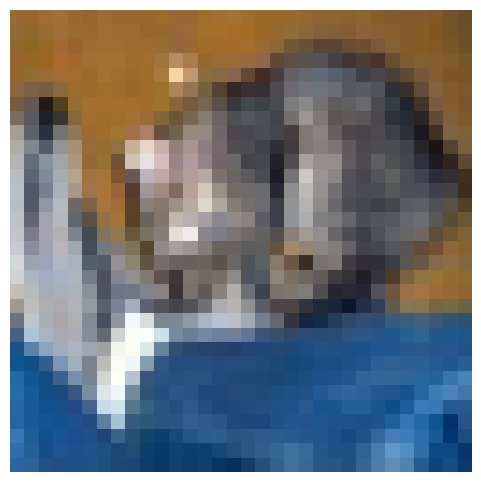

cat 

In [ ]:
#Defining plotting settings
plt.rcParams['figure.figsize'] = 14, 6

mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

#Initializing normalizing transform for the dataset
normalize_transform = torchvision.transforms.Compose([ torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(mean = mean,std = std)])

#Downloading the CIFAR10 dataset into train and test sets
test_dataset = torchvision.datasets.CIFAR10(root="./CIFAR10/test", train=False, transform=normalize_transform, download=True)

#Generating data loaders from the corresponding datasets
batch_size = 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

#Plotting the image
dataiter = iter(test_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(images, normalize=True, padding=1, nrow=1).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

# Printing Labels
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
               "horse", "ship", "truck"]
labels_now = labels[:10]
for x in labels_now.tolist():
  print(label_names[x], end=" ")

In [ ]:
data,_ = next(iter(test_loader))

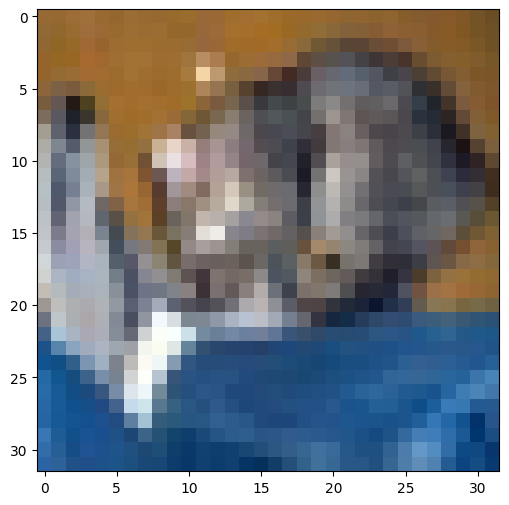

In [ ]:
plt.imshow(np.transpose(torchvision.utils.make_grid(
  data[0], normalize=True, padding=1, nrow=1).numpy(), (1, 2, 0)))

#Extract the features of pretrained VGG16 and generate Activation maps

In [ ]:
class Vgg16(nn.Module):
    def __init__(self):
        super().__init__()
        self.modules_no = [0,2,5,7,10,12,14,17,19,21,24,26,28]
        self.features = vgg16(pretrained=True).features
        self.features[4]  = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[9]  = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[16] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[23] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[30] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.avgpool = vgg16(pretrained=True).avgpool
        self.classifier = vgg16(pretrained=True).classifier


    def forward(self,x):
        results = {}
        maxpool_indices = {}
        for index,layer in enumerate(self.features):
            if index in [4,9,16,23,30]:
                x,i = layer(x)
                maxpool_indices[index] = i    #These index will be used during max_unpooling

            else :
                x = layer(x)

            if index in self.modules_no:
                results[index] = x

        return results,maxpool_indices


In [ ]:
#Allocate device to the model and data
model = Vgg16()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
#model = model.cuda()
data = data.to(device)


In [ ]:
with torch.no_grad():
    out,maxpool_ind = model(data)

In [ ]:
out_cpu = {}
for i in out:
    out_cpu[i]=out[i].cpu()


In [ ]:
out_cpu[0].size()

torch.Size([1, 64, 32, 32])

#Plot Activation Maps

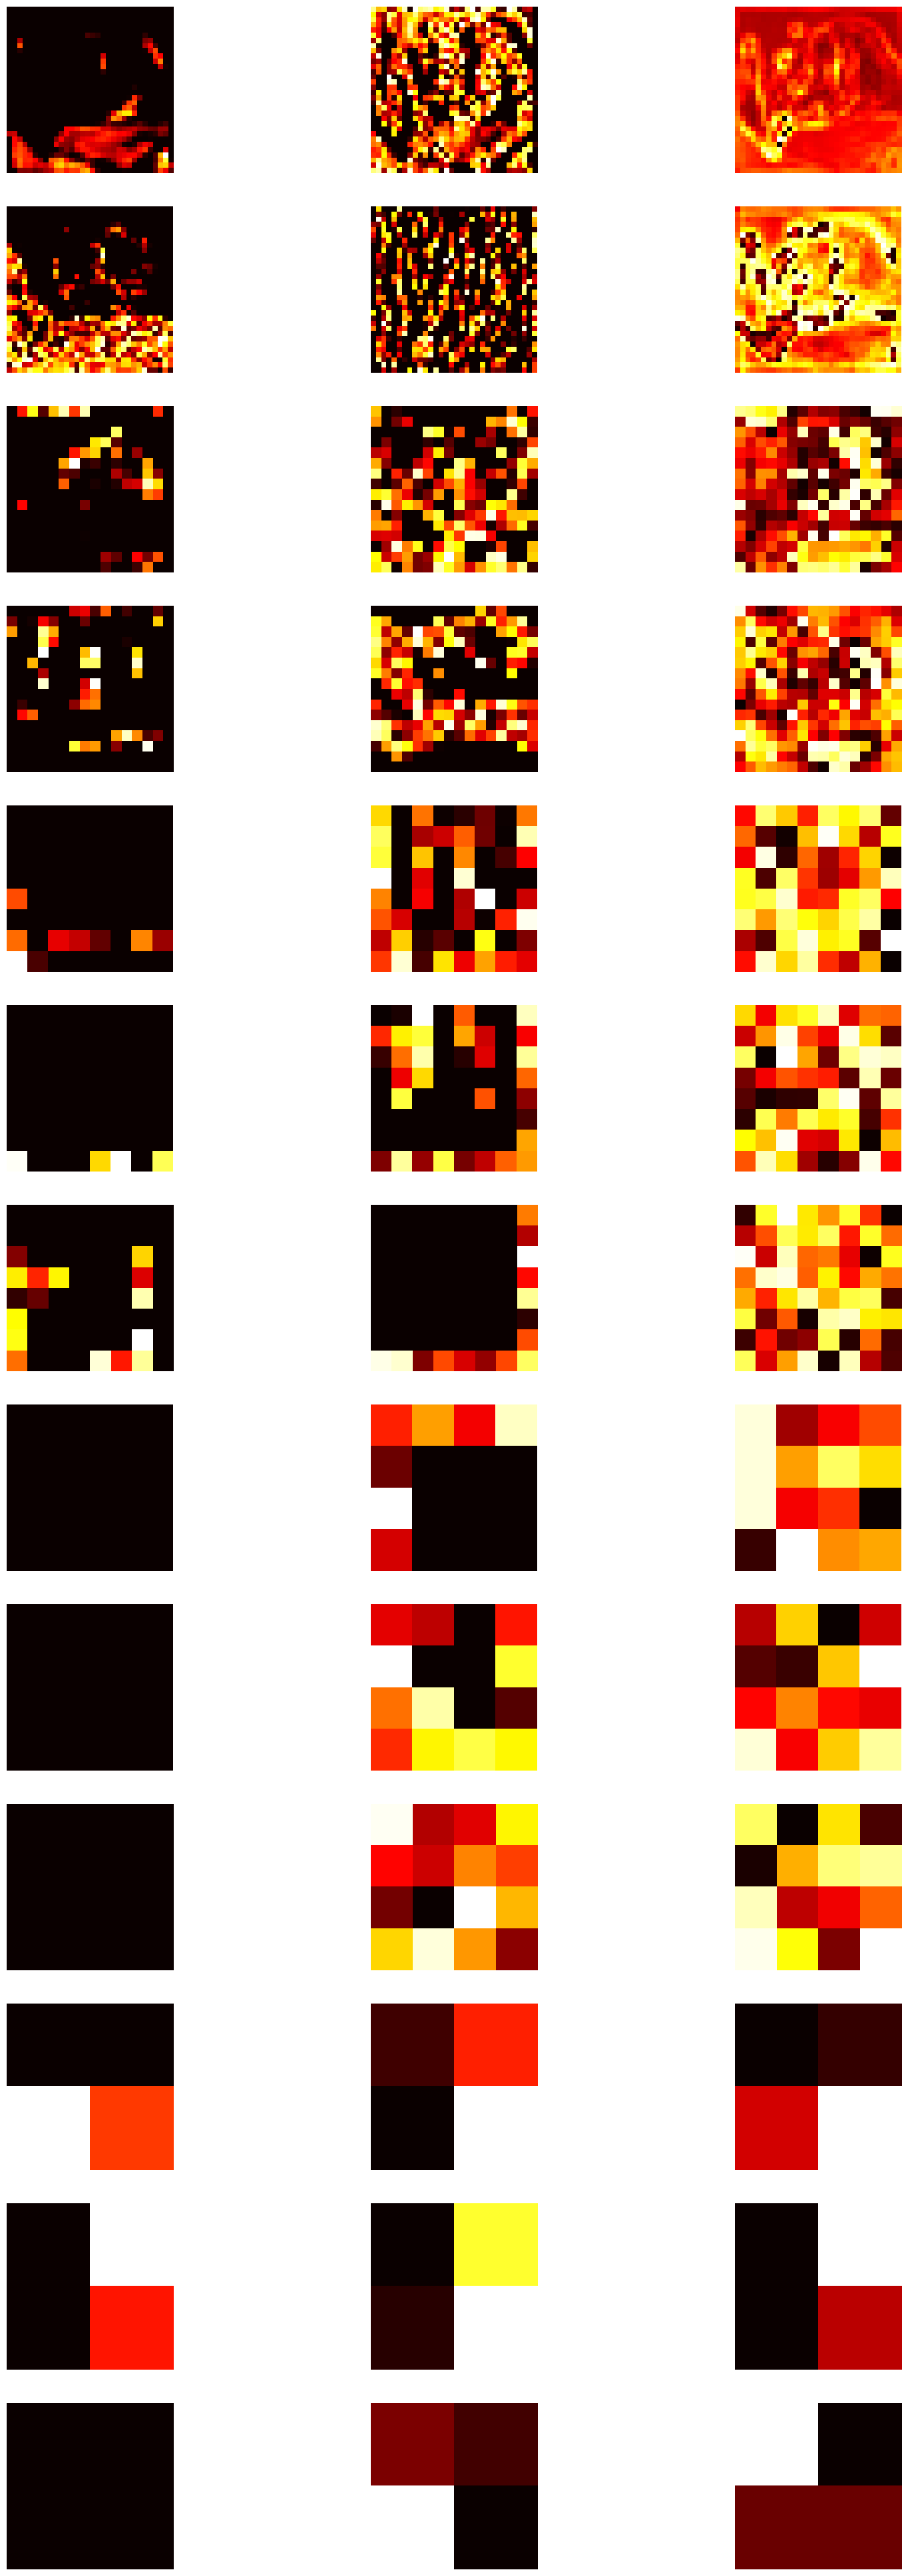

In [ ]:
ind = 1
plt.figure(figsize=[20,50])
for layer in out_cpu:
#   SELECTING A RANDOM ACTIVATION MAP
    filter_random = out_cpu[layer][0][np.random.randint(0,np.shape(out_cpu[layer])[1])]
    plot_loc = plt.subplot(13,3,ind)
    ind += 1
    vis = transforms.ToPILImage()(filter_random)
    plt.axis('off')
    plt.imshow(vis,cmap=plt.cm.hot)


#   SELECTING MAX ACTIVATION MAP
    filter_max = out_cpu[layer][0][0]
    max_norm = filter_max.norm()
    for filters in out_cpu[layer][0][1:]:
        if filters.norm() > max_norm :
            max_norm = filters.norm()
            filter_max = filters
    vis_max = transforms.ToPILImage()(filter_max)
    plot_loc = plt.subplot(13,3,ind)
    ind += 1
    plt.axis('off')
    plt.imshow(vis_max,cmap=plt.cm.hot)


#     CALCULATING MEAN OF ALL ACTIVATION MAPS IN THE LAYER
    mean = torch.zeros(np.shape(out_cpu[layer])[2],np.shape(out_cpu[layer])[3])
    for i in out_cpu[layer][0]:
        mean += i
    vis_mean = transforms.ToPILImage()(mean/np.shape(out_cpu[layer])[1])
    plot_loc = plt.subplot(13,3,ind)

    ind += 1
    plt.axis('off')
    plt.imshow(vis_mean,cmap=plt.cm.hot)
    #plt.colorbar()

#Deconvolution Network

In [ ]:
class Vgg16_deconv(nn.Module):
    def __init__(self):
        super().__init__()

        self.module_list = nn.ModuleList([
                           nn.MaxUnpool2d(kernel_size=2,stride=2),
                            nn.ReLU(),
                            nn.ConvTranspose2d(512,512,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.MaxUnpool2d(kernel_size=2,stride=2),
                            nn.ReLU(),
                            nn.ConvTranspose2d(512,512,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.MaxUnpool2d(kernel_size=2,stride=2),
                            nn.ReLU(),
                            nn.ConvTranspose2d(256,256,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(256,256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.MaxUnpool2d(kernel_size=2,stride=2),
                            nn.ReLU(),
                            nn.ConvTranspose2d(128, 128,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.MaxUnpool2d(kernel_size=2,stride=2),
                            nn.ReLU(),
                            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                            ])

        self.first_layer = nn.ModuleDict({
                            '2'  : nn.ConvTranspose2d(1,512,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '4'  : nn.ConvTranspose2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '6'  : nn.ConvTranspose2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '9'  : nn.ConvTranspose2d(1,512,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '11' : nn.ConvTranspose2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '13' : nn.ConvTranspose2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '16' : nn.ConvTranspose2d(1,256,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '18' : nn.ConvTranspose2d(1,256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '20' : nn.ConvTranspose2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '23' : nn.ConvTranspose2d(1, 128,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '25' : nn.ConvTranspose2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '28' : nn.ConvTranspose2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '30' : nn.ConvTranspose2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                            })


        self.conv2deconv_idx = {0:30 ,2:28 ,5:25 ,7:23 ,10:20 ,12:18 ,14:16 ,17:13 ,19:11 ,21:9 ,24:6 ,26:4 ,28:2 }
    #         deconv starts with maxpool and relu outputs

        self.unpool2pool_idx = {26:4 ,21:9 ,14:16 ,7:23 ,0:30 }
        self.deconv2conv_bias = {2:26 ,4:24 ,6:21 ,9:19 ,11:17 ,13:14 ,16:12 ,18:10 ,20:7 ,23:5 ,25:2 ,28:0 }

        self.initialize_weights()


    def initialize_weights(self):
        for i,f in enumerate(self.module_list):
            if isinstance(f,nn.ConvTranspose2d):
                f.weight.data = vgg16(pretrained = True).features[-i-1].weight.data.cuda()
                if i!=30:
                    f.bias.data = vgg16(pretrained = True).features[self.deconv2conv_bias[i]].bias.data


    def forward(self,x,layer_idx,map_idx,maxpool_indices):
        inp = x[layer_idx][0][map_idx].unsqueeze(0).unsqueeze(0)
        current_layer_idx = self.conv2deconv_idx[layer_idx]

        self.first_layer[str(current_layer_idx)].weight.data = vgg16(pretrained=True).features[layer_idx].weight[map_idx].data.unsqueeze(0).permute(0,1,3,2).cuda()
        inp = self.first_layer[str(current_layer_idx)](inp)
        current_layer_idx +=1

        for f in self.module_list[current_layer_idx : ]:
            if isinstance(f,nn.MaxUnpool2d):
               #print(maxpool_indices[self.unpool2pool_idx[current_layer_idx]].size())
                inp = f(inp,maxpool_indices[self.unpool2pool_idx[current_layer_idx]])
            else :
                inp = f(inp)
            current_layer_idx += 1
            #print(f)
            #print(inp.size())
        return inp





In [ ]:
deconvnet = Vgg16_deconv().to(device)

#Visualize the input patterns that contributed to specific activations.

0 	 58
2 	 10
5 	 107
7 	 44
10 	 50
12 	 252
14 	 14
17 	 304
19 	 454
21 	 329
24 	 268
26 	 240
28 	 456


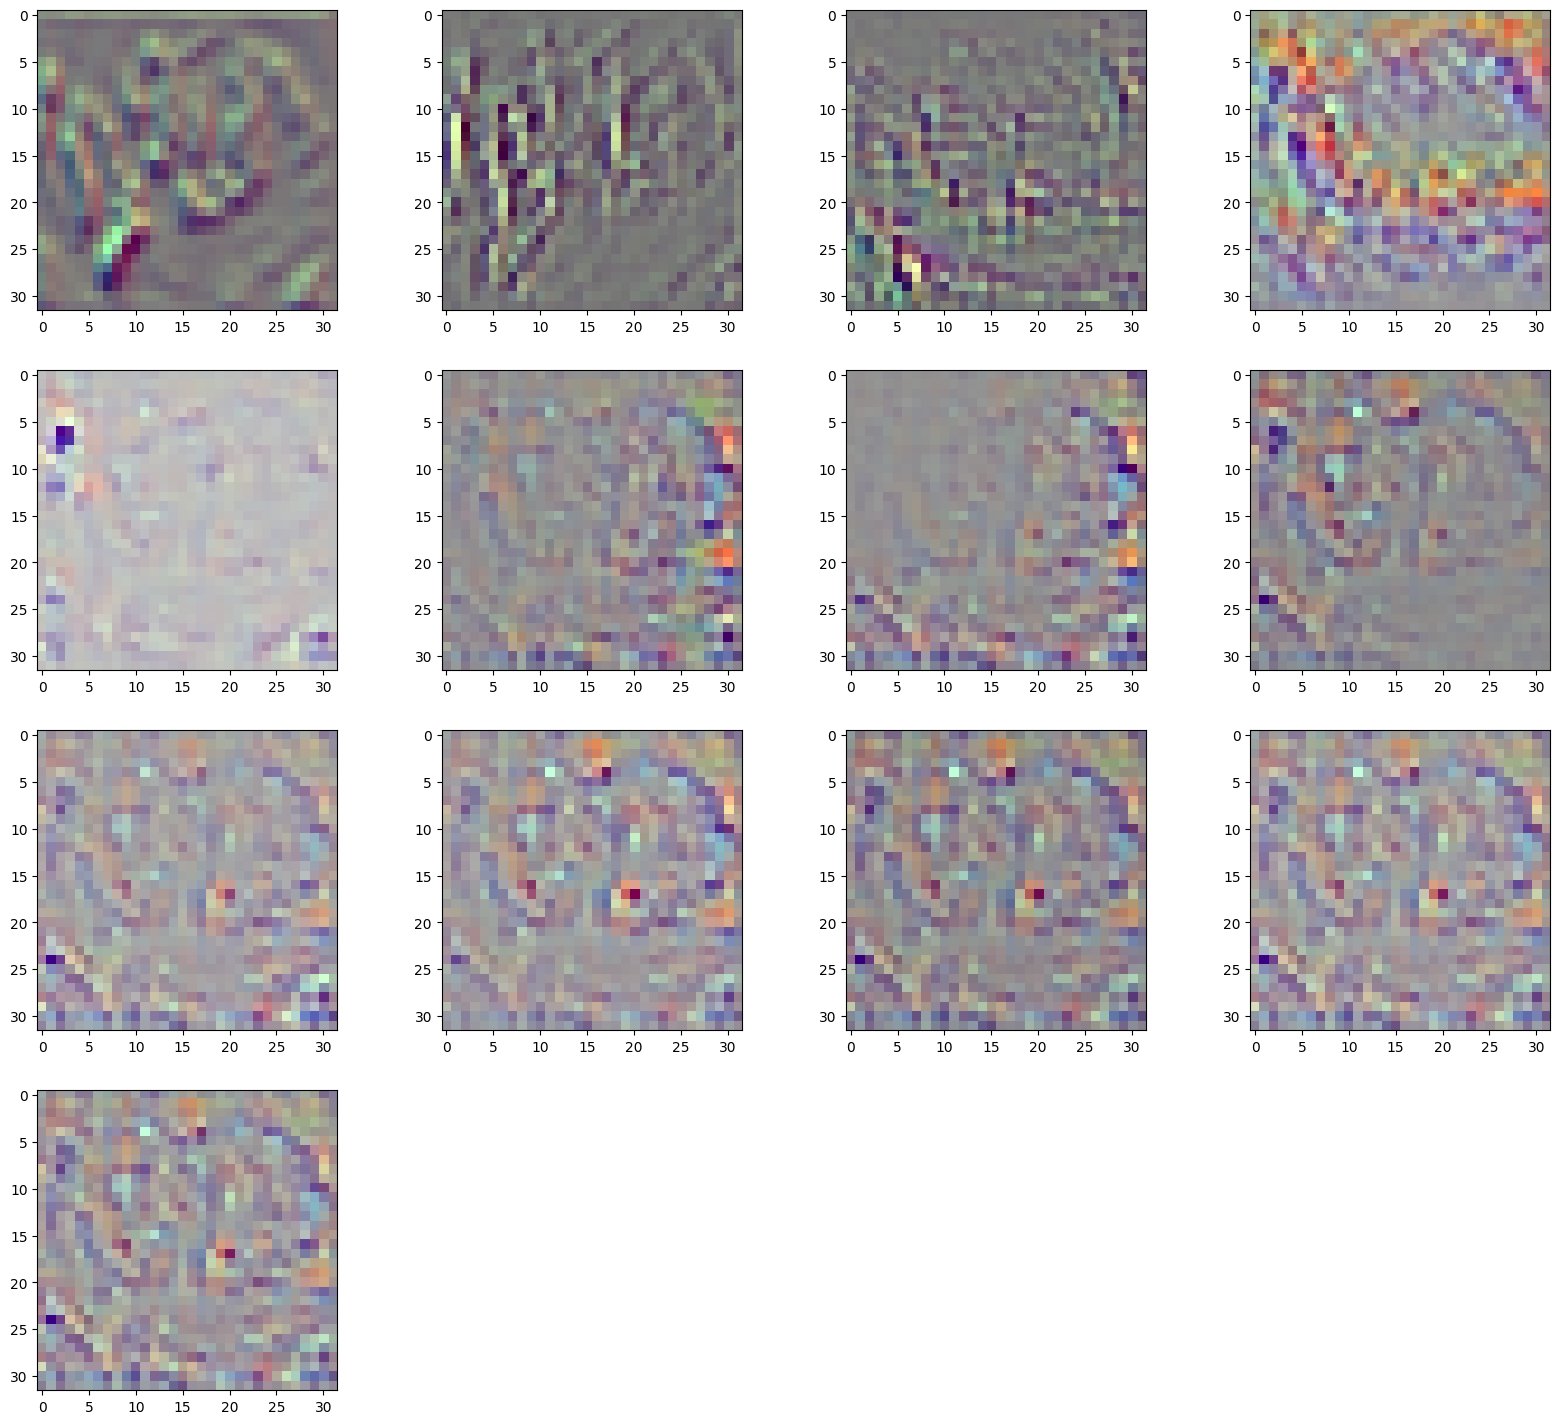

In [ ]:
ind = 1
plt.figure(figsize=[20,60])
for j in [0,2,5,7,10,12,14,17,19,21,24,26,28]:
        filter_max = out[j][0][0]
        max_norm = filter_max.norm()
        indexx = 1
        for i,filters in enumerate(out[j][0][1:]):
            if filters.norm() > max_norm :
                indexx = i+1
                max_norm = filters.norm()
                filter_max = filters
        print(j,"\t",indexx)

        with torch.no_grad():
            deconv_output = deconvnet(out ,j ,indexx ,maxpool_ind)

        deconv_output = deconv_output.cpu()
        plot_loc = plt.subplot(13,4,ind)
        ind += 1
        #plt.axis('off')
        plt.imshow(np.transpose(torchvision.utils.make_grid(deconv_output, normalize=True, padding=1, nrow=1).numpy(), (1, 2, 0)),cmap=plt.cm.hot)

